# Finetuning the Mobile Net(Light weight deep convolution neural network) for our custom dataset


---


*   Smaller in size and it's faster
*   Class of low power and low latency model used for classification ,detection etc
*   Due to it's small size it is used in mobile application






In [63]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
resnet = tf.keras.applications.resnet50.ResNet50()

102973440/102967424 [==============================] - 14s 0us/step


# **About the dataset**

---
This data set contains images of sign language digits. There are ten classes, labeled as 0 through 9, and each class is made up of images of hands showing the sign for that particular digit.



# **Organize The Data**
```
With code, we'll create the directories for the train,validation, and test 
sets, organize the images into their respective classes of 0 through 9 on
 disk, and then shuffle the data set and split the images into train, validation, and test sets.

In [17]:
os.chdir('D:/all projects/ml_mini_project/dataset_check')
if os.path.isdir('train/arduino_nano') is False: 
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')
    
    boards='arduino_nano', 'arduino_uno', 'msp430', 'raspberry_pi'
    
    for i in boards:
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')

        valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')

        test_samples = random.sample(os.listdir(f'train/{i}'), 5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
os.chdir('../..')

First, we create train, valid, and test directories.

We then move all class directories (0 - 9) with their respective images from Sign-Language-Digits-Datasetinto the train directory.


 
We then make class directories (0 - 9) for the valid and test data sets as well.

# **Process the data**

---



In [58]:
train_path = 'D:/all projects/ml_mini_project/dataset_check/train'
valid_path = 'D:/all projects/ml_mini_project/dataset_check/valid'
test_path = 'D:/all projects/ml_mini_project/dataset_check/test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 456 images belonging to 4 classes.
Found 120 images belonging to 4 classes.
Found 20 images belonging to 4 classes.


# **Build The Fine-Tuned Model**

In [20]:
#mobile = tf.keras.applications.resnet50.Resnet50()
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [21]:
x = resnet.layers[-1].output # Removing last 6 layers of mobile net

In [26]:
output = Dense(units=4, activation='softmax')(x) # Mobile net is a functional API.It's not sequential API

In [27]:
model = Model(inputs=resnet.input, outputs=output)

In [28]:
for layer in model.layers[:-23]: # Last 23 layers are trainable. The number 23 is used based on expriementation
    layer.trainable = False

In [29]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

# **Train The Model**

In [30]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
model.fit(x=train_batches,validation_data=valid_batches,epochs=5,verbose=2)

Epoch 1/5


C:\Users\amogh\anaconda3\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


46/46 - 100s - loss: 1.3489 - accuracy: 0.7237 - val_loss: 1.3202 - val_accuracy: 0.9667
Epoch 2/5
46/46 - 86s - loss: 1.3139 - accuracy: 0.9890 - val_loss: 1.3078 - val_accuracy: 0.9917
Epoch 3/5
46/46 - 92s - loss: 1.3033 - accuracy: 0.9912 - val_loss: 1.2996 - val_accuracy: 0.9917
Epoch 4/5
46/46 - 98s - loss: 1.2952 - accuracy: 0.9846 - val_loss: 1.2913 - val_accuracy: 0.9917
Epoch 5/5
46/46 - 95s - loss: 1.2870 - accuracy: 0.9868 - val_loss: 1.2842 - val_accuracy: 0.9917


# **Use The Model For Inference**

In [45]:
test_labels


array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3])

In [48]:
predictions = model.predict(x=test_batches,verbose=0)

In [49]:
test_labels=test_batches.classes

In [50]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [51]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [52]:
test_batches.class_indices

{'arduino_nano': 0, 'arduino_uno': 1, 'msp430': 2, 'raspberry_pi': 3}

Confusion matrix, without normalization
[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 0 5]]


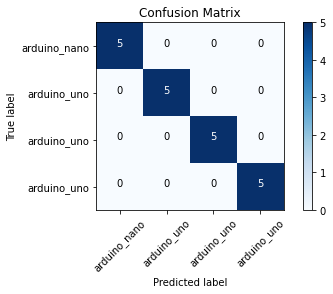

In [53]:
cm_plot_labels = ['arduino_nano','arduino_uno','arduino_uno','arduino_uno']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [54]:
#inference

In [71]:
from keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions
import numpy as np

In [103]:
img_path='D:/all projects/ml_mini_project/dataset_check/test/raspberry_pi/Raspberry PI_12.png'
img=image.load_img(img_path,target_size=(224, 224))

In [104]:
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
x=preprocess_input(x)

In [105]:
pred=model.predict(x)
pred

array([[0.25509328, 0.23646492, 0.24018568, 0.26825607]], dtype=float32)

In [106]:
y_pred=np.argmax(pred,axis=1)
y_pred

array([3], dtype=int64)

In [110]:
model.save('D:/all projects/ml_mini_project/all_boards_model.h5')

In [111]:
tf.__version__

'2.5.0'